In [1]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config

In [2]:
"""
    Description: Function for splitting a dataframe into training and testing set
    @param [Pandas Dataframe] df: The dataframe with audio features
    @param [Boolean] showsize: True or False for wanting to print the sizes of each dataset
    Return: [Array, Array, Array] The list of training samples, testing samples and output for the test set
"""

def split_dataset(df, showsize):
    df = df.drop(columns=["Path"]) # delete paths column
    train_data = df.sample(frac=0.8, random_state=25)
    test_data = df.drop(train_data.index) # the rest of the files in the original df after picking out the train_data
    y_test = test_data["isLeak"] 
    test_data = test_data.drop(columns=["isLeak"]) # delete isLeak column to prove there is no cheating
    if showsize == True:
        print('Train size: ' + str(len(train_data)- int(len(train_data)*0.1)) + ', Validation size: ' + str(int(len(train_data)*0.1)) + ', Test size: ' + str(len(test_data)))
    return train_data, test_data, y_test

"""
    Description: Function for training models
    @param [Array] train_data: The list of training samples
    @param [String] path: name of path for saving the trained predictor-model
    @param [String] modeltype: The name of the model-type to use (Neural networks or Gradient Boosting)
    Return: [Tabular Predictor] The trained predictor object
"""

def train_models(train_data, path, modeltype):
    save_path = path 
    predictor = TabularPredictor(label="isLeak", path=save_path).fit(train_data, hyperparameters={modeltype:{}})
    return predictor

"""
    Description: Function for testing models
    @param [Tabular Predictor] predictor: The trained predictor model
    @param [Array] test_data: The list of testing samples
    Return: [Array] List of predicted class for each input sample in the test set
"""
def test_model(predictor, test_data):
    y_pred = predictor.predict(test_data)
    predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    return y_pred

"""
    Description: Function for visualizing the predicted and true values in a Confusion Matrix
    @param [Tabular Predictor] predictor: The trained predictor model
    @param [Array] y_test: The list of true labels for the test set
    @param [Array] y_pred: The list of predicted labels for the test set
    Return: None, but plots the Confusion matrix as a heatmap
"""
def create_confusion_matrix(predictor, y_test, y_pred):
    leaders = predictor.leaderboard()
    best_model = str(leaders.head(1)['model'][0])
    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontdict={'size':'15'})
    ax.set_ylabel('Actual', fontdict={'size':'15'})
    ax.set_title('Confusion Matrix of '+ str(best_model), fontsize='16')
    ax.xaxis.set_ticklabels(['No Leakage', 'Leakage']); ax.yaxis.set_ticklabels(['No Leakage', 'Leakage'])
    
"""
    Description: Function for finding the importance of the features in the dataset
    @param [Tabular Predictor] predictor: The trained predictor model
    @param [Pandas Dataframe] df: The dataframe of features
    Return: [Pandas Dataframe] Dataframe of calculated scores for each feature
"""    
def get_feature_importance(predictor, df):
    importance = predictor.feature_importance(data=df)
    return importance

"""
    Description: Function for showing information on metadata and hyperparameters of the model
    @param [Tabular Predictor] predictor: The trained predictor model
    Return: [Dictionary] Informative dictionary of the best model 
"""    
def get_model_info(predictor):
    leaders = predictor.leaderboard()
    best_model_name = leaders[leaders['stack_level'] == 1]['model'].iloc[0]
    best_model_info = predictor.info()['model_info'][best_model_name]
    return best_model_info

"""
    Description: Function for showing the correlations of the features in a heatmap
    @param [Pandas Dataframe] df: The dataframe of audio features
    Return: None, but plots the Correlation matrix as a heatmap
"""   
def create_correlation_matrix(df, dropcolumns):
    plt.figure(figsize=(17, 8))
    df = df.drop(columns=dropcolumns)
    correlations = df.corr()
    heatmap = sns.heatmap(correlations, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap of Audio Features', fontdict={'fontsize':12}, pad=12)
    

In [3]:
"""
    This part of the program requires action by the user. The user needs to define which
"""    

df_tube = pandas.read_csv('new_features_tube.csv')
df_vent = pandas.read_csv('new_features_vent.csv')
df_both = pandas.concat([df_vent, df_tube], axis=0, ignore_index=True)


"""
     Uncomment all the three rows underneeth in order to run the initial feature combination with 18 features
"""
df_tube = df_tube.drop(columns=['RMS 4-20kHz'])
df_vent = df_vent.drop(columns=['RMS 4-20kHz'])
df_both = df_both.drop(columns=['RMS 4-20kHz'])

"""
     Uncomment all the three rows underneeth in order to run the alternative feature combination with 12 features
"""
#df_tube = df_tube.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz'])
#df_vent = df_vent.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz'])
#df_both = df_both.drop(columns=['Bandwidth', 'RMS 4-8kHz', 'RMS 8-12kHz', 'RMS 12-16kHz', 'RMS 16-20kHz', 'Centroid 4-8kHz', 'RMS 4-20kHz'])

"""
    Define which of the dataframes that shall be used as input to the ML algorithms. Either "df_tub", "dt_vent" or "df_both".
"""
df = df_both

train_data, test_data, y_test = split_dataset(df, True)

Train size: 2627, Validation size: 291, Test size: 730


In [4]:
# Defining the name of the path/folder for which the model shall be saved to
path = 'Predictor-test'

"""
     Uncomment the rows underneeth one by one in order to run the AutoML process for each model type separately
"""
#modeltype = 'NN_TORCH'
#modeltype = 'FASTAI'
#modeltype = 'XGB'
modeltype = 'CAT'

predictor = train_models(train_data, path, modeltype)

Beginning AutoGluon training ...
AutoGluon will save models to "Predictor-test\"
AutoGluon Version:  0.4.0
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    2918
Train Data Columns: 18
Label Column: isLeak
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    879.55 MB
	Train Data (Original)  Memory Usage: 0.42 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features

In [5]:
"""
    This code runs the model on the testing dataset and prints the evaluation metrics. 
"""

y_pred = test_model(predictor, test_data)

Evaluation: accuracy on test data: 0.9424657534246575
Evaluations on test data:
{
    "accuracy": 0.9424657534246575,
    "balanced_accuracy": 0.9413567035393247,
    "mcc": 0.8889842703839952,
    "f1": 0.9380530973451328,
    "precision": 0.9906542056074766,
    "recall": 0.8907563025210085
}


                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             CatBoost      0.944       0.004985  4.310581                0.004985           4.310581            1       True          1
1  WeightedEnsemble_L2      0.944       0.005983  4.314557                0.000998           0.003977            2       True          2


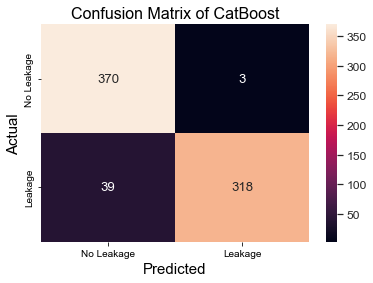

In [6]:
"""
    This code displays the confusion matrix for the testing dataset
"""
create_confusion_matrix(predictor, y_test, y_pred)

In [7]:
"""
    This code print the feature importance table for the model
"""

importance = get_feature_importance(predictor, df)
importance

These features in provided data are not utilized by the predictor and will be ignored: ['Path']
Computing feature importance via permutation shuffling for 18 features using 1000 rows with 3 shuffle sets...
	2.0s	= Expected runtime (0.67s per shuffle set)
	0.41s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Centroid 20-24kHz,0.277000,0.024556,0.001305,3,0.417709,0.136291
RMS 20-24kHz,0.083667,0.003786,0.000341,3,0.105361,0.061973
RMS 0-4kHz,0.023667,0.009018,0.022575,3,0.075344,-0.028010
Centroid 0-4kHz,0.023000,0.003000,0.002812,3,0.040190,0.005810
MAX_AMP >20kHz,0.018000,0.004583,0.010465,3,0.044259,-0.008259
Rolloff,0.016667,0.004933,0.013990,3,0.044933,-0.011599
Centroid 16-20kHz,0.016000,0.003464,0.007634,3,0.035850,-0.003850
Mic,0.015667,0.007572,0.034904,3,0.059054,-0.027721
RMS 8-12kHz,0.010667,0.000577,0.000488,3,0.013975,0.007358
Bandwidth,0.009667,0.001155,0.002361,3,0.016283,0.003050


In [8]:
"""
    Prints information on the best model
"""

best_model_info = get_model_info(predictor)
best_model_info

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             CatBoost      0.944       0.004985  4.310581                0.004985           4.310581            1       True          1
1  WeightedEnsemble_L2      0.944       0.005983  4.314557                0.000998           0.003977            2       True          2


{'name': 'CatBoost',
 'model_type': 'CatBoostModel',
 'problem_type': 'binary',
 'eval_metric': 'accuracy',
 'stopping_metric': 'accuracy',
 'fit_time': 4.310580730438232,
 'num_classes': 2,
 'quantile_levels': None,
 'predict_time': 0.00498509407043457,
 'val_score': 0.944,
 'hyperparameters': {'iterations': 10000,
  'learning_rate': 0.05,
  'random_seed': 0,
  'allow_writing_files': False,
  'eval_metric': 'Accuracy'},
 'hyperparameters_fit': {'iterations': 116},
 'hyperparameters_nondefault': [],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': ['bool', 'int', 'float', 'category'],
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
  'get_features_kwargs_extra': None,
  'predict_1_batch_size': None},
 'num_features': 18,
 'features': ['Mic',
  'Bandwidth',
  'Rolloff',
  'Flatness',
  'Centroid 0-4kHz',

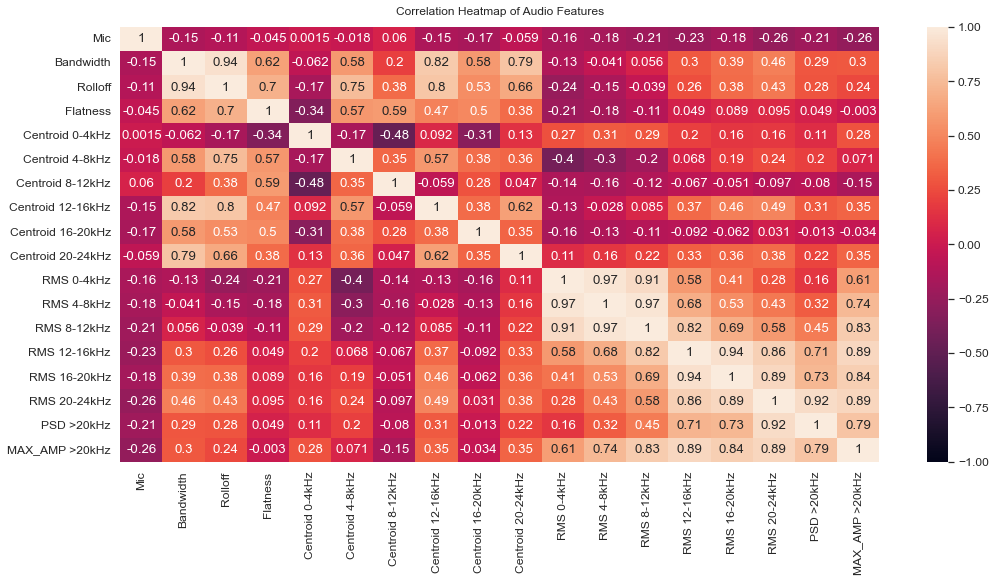

In [9]:
"""
    This code displays the feature correlation map for the features in the dataset
"""
dropcolumns = ['isLeak']
create_correlation_matrix(df, dropcolumns)

In [10]:
"""
    This code prints statistical information of a chosen feature from the dataset. 
    The user has to define which feature to describe by changing 'Bandwidth' to the desired feature name
"""
feature = 'Bandwidth'
print("Summary of class variable:\n", train_data[feature].describe())

Summary of class variable:
 count    2918.000000
mean        0.419899
std         0.285731
min         0.000000
25%         0.148371
50%         0.362604
75%         0.681068
max         1.000000
Name: Bandwidth, dtype: float64
